<a href="https://colab.research.google.com/github/hui509/Prediction-of-quality-of-Wine/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C%EF%BD%9C%E7%B4%85%E9%85%92%E5%93%81%E8%B3%AA%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **專題實作｜紅酒品質預測**

# 目標：利用現有資料集訓練一個有效的模型，協助判斷紅酒品質好壞。

# **載入 `Red Wine Quality` 資料集**



In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv')
df

# **資料概況**

**1. Red Wine Quality 各欄位定義**

* fixed acidity : 非揮發性酸
* volatile acidity : 揮發性酸
* citric acid : 檸檬酸
* residual sugar : 殘留糖分
* chlorides : 氯化物
* free sulfur dioxide : 游離二氧化硫
* total sulfur dioxide : 總二氧化硫
* density : 密度
* pH : pH值
* sulphates : 硫酸鹽
* alcohol : 酒精濃度
* qulity : 品質 (分數介於0 - 10)


**2. 觀察每個「特徵」欄位（除 quality 外）資料的分佈情況**

* 品質越好的紅酒，檸檬酸(citric acid)、硫酸鹽(sulphates)越高。
* 品質越好的紅酒，揮發性酸度(volatile acidity)、氯化物(chlorides)越少。
* 密度(density)對紅酒品質不具有區別性，皆大約為1。
* pH值對紅酒品質區別性也很小，大約落在3左右。




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# 創建一個3x4的圖
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

# 將axes攤平為一維矩陣，以利後續遍歷
axes = axes.flatten()

# 定義資料欄位的索引
column_index = 0

# 長條圖呈現各特徵的分布
for i in df.columns:
  if i != 'quality':
    sns.barplot(data=df, x='quality', y=i, palette='coolwarm', ax=axes[column_index])
    axes[column_index].set_title(i)
    column_index += 1

# 刪除最後一個空白圖表
axes[-1].remove()

# 調整子圖之間的間距
plt.tight_layout()

# 輸出圖表
plt.show()

**3. 觀察每個「標籤」欄位（quality）資料的分佈情況**

* 資料中的 quality 介於3-8分之間。
* 獲得5、6分 quality 的紅酒占多數，共有1319筆，呈現不平衡情況


In [ ]:
# 計算不同quality的筆數
df['quality'].value_counts()

In [ ]:
# 計數圖呈現quality的分布
sns.countplot(data=df, x='quality', palette='coolwarm')

**4. 觀察各特徵之間的關係**

* Pearson 相關分析中，小於0.3為低相關，介於0.3~0.7為中等相關，大於0.7為高度相關
* 酒精濃度(alcohol)與紅酒品質有(0.48)的相關性，有較高的正相關。
* 揮發性酸度(volatile acidity)與紅酒品質有(-0.39)的相關性，有較高的負相關。



In [ ]:
# 計算相關性
cor = df.corr()

# 使用seaborn和matplotlib，視覺化呈現
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,linewidth=0.5,cmap='coolwarm')
plt.title('Correlation Matrix of Red Wine Quality')
plt.show()

# **資料處理**

**1. 資料清理與型態轉換**

* 資料中沒有缺失值，無須進行填補。
* 資料中除quality欄位為int型態，其餘為float型態，皆可投入模型。



In [ ]:
# 確認是否有缺失值
df.isnull().sum()

In [ ]:
# 確認資料型態是否符合模型需求
df.info()

**2. 處理標籤欄位(quality)**

* 原始quality介於3-8分，依據分數無法直接判斷「好或壞」，且存在資料不平衡。
* 二元分類quality並進行型態轉換，區分為good(1)、bad(0)，結果依舊存在資料不平衡。

In [187]:
# 以6.5分為基準，將quality分為good和bad
bins = (0, 6.5, 10)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [188]:
# 型態轉換：quality原為有序數值，故使用Labelencoder將good轉為1，bad轉為0
from sklearn.preprocessing import LabelEncoder
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

In [ ]:
# 計數圖呈現分類後的quality分布
sns.countplot(data=df, x='quality', palette='coolwarm')

**3. 特徵工程**

* 以 Standardize 正規化調整 quality 欄位資料差距大的情況


In [190]:
# 資料正規化 - Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_columns = df.columns.difference(["quality"])
df[feature_columns] = scaler.fit_transform(df[feature_columns])


# **模型分析**

**1. 使用少數類過採樣技術(SMOTE)方法，處理資料不平衡問題**

**2. 採用 scikit-learn 五種基本模型進行分析與比較**

* 邏輯回歸 Logistic Regression
* 支持向量機 Support Vector Machines
* 決策樹 Decision Tree Classifier
* 隨機森林 Random Forest Classifier
* K-近鄰演算法 K Nearest Neighbor


In [191]:
# 載入模型
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [192]:
# 拆分訓練集與測試集
X = df.drop('quality', axis = 1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 使用SMOTE，處理資料不平衡問題
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [193]:
# Scikit-learn 五種基本模型分析
models = {
    'Logistic Regression':LogisticRegression(random_state=0,max_iter=3000),
    'SVC':SVC(),
    'Decision Tree Classifer':DecisionTreeClassifier(),
    'Random Forest Classifer':RandomForestClassifier(),
    'KNN':KNeighborsClassifier()
      }
scores = [ ]
for model_name,model in models.items():
  score = cross_val_score(model,X_train_resampled,y_train_resampled.values.ravel(),cv=5,scoring='accuracy').mean()
  scores.append({'model':model_name, 'accuracy':score})

# **模型優化**

**1. 使用 GridSearchCV( ) 調整參數**




In [194]:
# 超參數調整
from sklearn.model_selection import GridSearchCV
model_params = {
  'Logistic Regression(Opt)':{
      'model':LogisticRegression(),
      'params':{'C': [0.01, 0.1, 1, 10],'solver': ['liblinear','lbfgs']}
              },
  'SVC(Opt)':{
      'model':SVC(),
      'params':{'C':[0.1,1,10],'kernel':['rbf'],'gamma':[0.05, 0.1]}
      },
  'Decision Tree Classifier(Opt)':{
      'model':DecisionTreeClassifier(),
      'params':{'criterion': ['gini', 'entropy'],'max_depth': [4, 6, 8],
            'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
          },
  'Random Forest Classifier(Opt)':{
      'model':RandomForestClassifier(),
      'params':{'n_estimators': [10, 50],'max_depth': [4, 6, 8],'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt']}
          },
  'KNN(Opt)':{
      'model':KNeighborsClassifier(),
      'params':{'n_neighbors': [3, 5, 7, 9],'weights': ['uniform', 'distance']}
      }
  }

scores_opt = []
for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'],mp['params'],cv=5)
  score = cross_val_score(mp['model'],X_train_resampled,y_train_resampled.values.ravel(),cv=5,scoring='accuracy').mean()
  scores_opt.append({'model':model_name,'accuracy':score})

In [195]:
# 比較超參數調整前後結果
combined = scores + scores_opt
df = pd.DataFrame(combined)
df.sort_values(by='accuracy',ascending=False)

,model,accuracy
8,Random Forest Classifier(Opt),0.939141
3,Random Forest Classifer,0.937790
7,Decision Tree Classifier(Opt),0.887741
2,Decision Tree Classifer,0.882781
4,KNN,0.873755
9,KNN(Opt),0.873755
1,SVC,0.865644
6,SVC(Opt),0.865644
0,Logistic Regression,0.791261
5,Logistic Regression(Opt),0.791261


**2. 使用PyTorch、TensorFlow模型進行分析**

In [196]:
# 切割訓練集、測驗集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2)

In [197]:
# TensorFlow
import tensorflow as tf
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=2)

In [198]:
# PyTorch
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# 創建模型架構
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size)
        self.hidden2 = torch.nn.Linear(hidden_size, hidden_size)
        self.predict = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output1 = self.hidden1(x)
        output2 = self.hidden2(output1)
        output = F.softmax(self.predict(output2))
        return output

# 模型、優化器初始化
model = Model(X_test.shape[1], 32, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0) # 模型參數優化器
loss_func = torch.nn.CrossEntropyLoss()

# 資料格式轉成torch專用格式
x_data = torch.tensor(X_train.values, dtype=torch.float32) # [120, 4]
y_data = torch.tensor(y_train_onehot, dtype=torch.float32) # [120, 3]
x_test_data = torch.tensor(X_test.values, dtype=torch.float32) # [120, 4]
y_test_data = torch.tensor(y_test_onehot, dtype=torch.float32) # [120, 3]

batch_size = 16
num_epochs = 100
num_batches = len(X_train) // batch_size
loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        prediction = model(x_data[start:end])
        loss = loss_func(prediction, y_data[start:end])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss_func(model(x_data), y_data)
    loss_list.append(loss.item())

    test_loss = loss_func(model(x_test_data), y_test_data)
    test_loss_list.append(test_loss.item())

print(loss_list)
print(test_loss_list)

<ipython-input-198-033d57411844>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.predict(output2))


[0.5983354449272156, 0.5522444248199463, 0.5218145847320557, 0.5011332035064697, 0.4866246283054352, 0.47612565755844116, 0.4682973623275757, 0.46228957176208496, 0.45754945278167725, 0.4537097215652466, 0.4505220055580139, 0.4478159546852112, 0.44547390937805176, 0.4434146583080292, 0.44158247113227844, 0.43993914127349854, 0.4384583532810211, 0.43712127208709717, 0.4359131455421448, 0.43482133746147156, 0.4338344633579254, 0.43294164538383484, 0.4321325123310089, 0.43139758706092834, 0.4307282269001007, 0.4301166236400604, 0.4295560419559479, 0.42904043197631836, 0.42856472730636597, 0.42812442779541016, 0.4277157187461853, 0.427335262298584, 0.4269801378250122, 0.42664796113967896, 0.4263363778591156, 0.42604365944862366, 0.4257678687572479, 0.42550766468048096, 0.4252617061138153, 0.4250287711620331, 0.4248078465461731, 0.42459797859191895, 0.42439839243888855, 0.4242081046104431, 0.4240267276763916, 0.42385348677635193, 0.42368775606155396, 0.4235292077064514, 0.4233771562576294, 

Text(0, 0.5, 'BCE Loss')

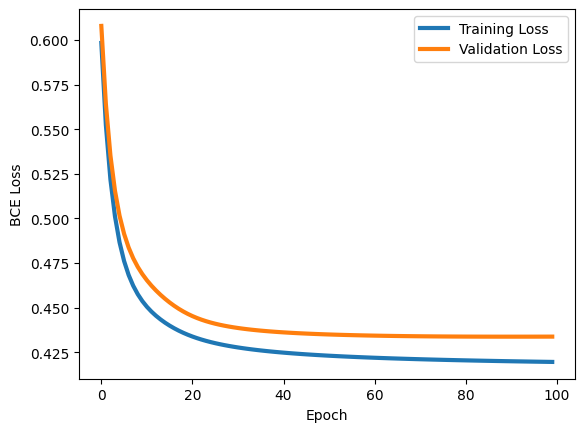

In [199]:
# 視覺化呈現結果
import matplotlib.pyplot as plt
plt.plot(loss_list, linewidth=3)
plt.plot(test_loss_list, linewidth=3)
plt.legend(('Training Loss','Validation Loss'))
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')